In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import cv2
import sys
sys.setrecursionlimit(25000)

In [2]:
img = cv2.imread("./data/talhao_101035/interest_b0420201015.tif", -1)
#img = cv2.imread("./data/talhao_100767/interest_b0420201015.tif", -1)
img8 = cv2.convertScaleAbs(img, alpha=0.03)
line_image = np.copy(img8) * 0  # creating a blank to draw lines on

img_eq = cv2.equalizeHist(img8)
img_blur = cv2.GaussianBlur(img8, (5,5), 0 )
img_lap = cv2.Laplacian(img8, cv2.CV_64F)
img_lap = np.uint8(np.absolute(img_lap))

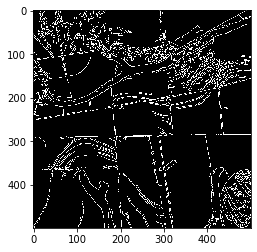

In [19]:
edges = cv2.Canny(img8,10,50, None)
plt.imshow(edges,cmap = 'gray')
plt.show()


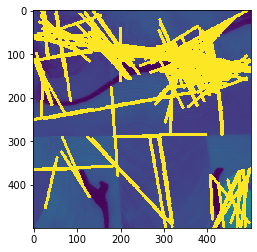

In [31]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 20
# maximum gap in pixels between connectable line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
line_image = np.copy(img8) * 0  # creating a blank to draw lines on
img_copy = np.copy(img8)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

# Draw the lines on the  image
lines_edges = cv2.addWeighted(img_copy, 1, line_image, 1, 0)
plt.imshow(lines_edges)
plt.show()

#plt.imshow(line_image)
#plt.show()

29


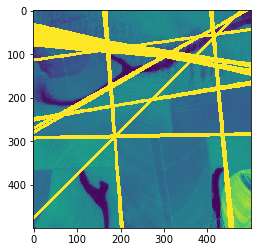

In [72]:
_rho = 1  # distance resolution in pixels of the Hough grid
_theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 132  # minimum number of votes (intersections in Hough grid cell)

edges2 = cv2.Canny(img8,10,50, None)

img_hough = np.copy(img8)
img_copy = np.copy(img8)

lines = cv2.HoughLines(edges2, _rho, _theta, threshold)

print( len(lines))

for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img_hough, (x1, y1), (x2, y2), (255, 0, 0), 5)
    
    
# Draw the lines on the  image
lines_edges2 = cv2.addWeighted(img_copy, 0.8, img_hough, 1, 0)
plt.imshow(lines_edges2)
plt.show()